In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from chainer import cuda, Variable, FunctionSet, optimizers
import chainer.functions as F
import sys
import csv

plt.style.use('ggplot')

In [36]:
# 確率的勾配降下法におけるミニバッチ数
batchsize = 50

# 学習の繰り返し回数
n_epoch = 20

# 中間層の数
n_units = 4


#=================================================
# csvファイルからデータを取り出し、listに格納
def set_data():

        filename = "../../../data/misyo/data_standardized"
        
        f = open('%s.csv' % filename, 'rU')
        data = csv.reader(f)

        data_set = []
        target_set = []
        for line in data:
                data_set.append(line[1:4])
                target_set.append(line[4])
        f.close()
        np_dataSet = np.array(data_set, dtype=np.float32)
        np_targetSet = np.array(target_set, dtype=np.int32)
        return np_dataSet, np_targetSet

#=================================================

data, target = set_data()

# <!--- start_debug
#print data.shape
#print target.shape
#       end_debug ----> 


# 学習用データをN個、検証用データを残りの個数と設定
# Nの値は暫定的なもの
N = 1200
x_train, x_test = np.split( data, [N])  
y_train, y_test = np.split( target, [N]) 
N_test = y_test.size
#print data
#print target



In [37]:
# 多層パーセプトロンモデルの設定
# 入力 3次元、出力 2次元
model = FunctionSet(l1=F.Linear(3, n_units),
                    l2=F.Linear(n_units, n_units),
                    l3=F.Linear(n_units, n_units),
                    l4=F.Linear(n_units, n_units),
                    l5=F.Linear(n_units, 2))

# Neural net architecture
# ニューラルネットの構造
def forward(x_data, y_data, train=True ):
        x, t = Variable(x_data), Variable(y_data)
        h1 = F.dropout(F.relu(model.l1(x)), ratio=.0, train=train)
        h2 = F.dropout(F.relu(model.l2(h1)), ratio=.0, train=train)
        h3 = F.dropout(F.relu(model.l3(h2)), ratio=.0, train=train)
        h4 = F.dropout(F.relu(model.l4(h3)), ratio=.0, train=train)
        y = model.l5(h4)
        # 0/1の2クラス分類なので誤差関数として、ソフトマックス関数
        # を用いて、誤差を導出
        return F.softmax_cross_entropy(y, t), F.accuracy(y, t)



In [38]:
# Setup optimizer
optimizer = optimizers.Adam()
optimizer.setup(model)

train_loss = []
train_acc= []
test_loss = []
test_acc = []

l1_W = []
l2_W = []
l3_W = []
l4_W = []
l5_W = []



epoch 1
train mean loss=0.692179178198, accuracy=0.405833334352
test  mean loss=0.69301536841, accuracy=0.519573642302
epoch 2
train mean loss=0.684222867091, accuracy=0.533333337555
test  mean loss=0.686044189357, accuracy=0.678294575954
epoch 3
train mean loss=0.675239764154, accuracy=0.688333339989
test  mean loss=0.677784725215, accuracy=0.699224809344
epoch 4
train mean loss=0.664293217162, accuracy=0.710000000894
test  mean loss=0.666206084019, accuracy=0.734108524729
epoch 5
train mean loss=0.649895340204, accuracy=0.736666666965
test  mean loss=0.651806884034, accuracy=0.75872092284
epoch 6
train mean loss=0.633011656503, accuracy=0.746666664879
test  mean loss=0.633158586746, accuracy=0.76879844647
epoch 7
train mean loss=0.614307016134, accuracy=0.751666662594
test  mean loss=0.613342789254, accuracy=0.775968989199
epoch 8
train mean loss=0.596272354325, accuracy=0.763333335519
test  mean loss=0.594466730606, accuracy=0.778294568376
epoch 9
train mean loss=0.581126714746, acc

[]

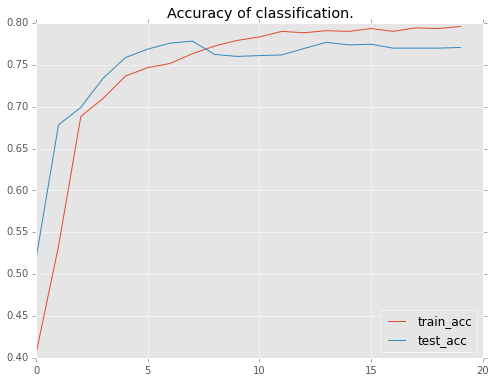

In [39]:
# Learning loop
for epoch in xrange(1, n_epoch+1):
        print 'epoch', epoch

        # training
        # N個の順番をランダムに並び替える
        perm = np.random.permutation(N)
        sum_accuracy = 0
        sum_loss = 0
        # 0〜Nまでのデータをバッチサイズごとに使って学習
        for i in xrange(0, N, batchsize):
                x_batch = x_train[perm[i:i+batchsize]]
                y_batch = y_train[perm[i:i+batchsize]]

                # 勾配を初期化
                optimizer.zero_grads()
                # 順伝播させて誤差と精度を算出
                loss, acc = forward(x_batch, y_batch)
                # 誤差逆伝播で勾配を計算
                loss.backward()
                optimizer.update()
                sum_loss += float(cuda.to_cpu(loss.data)) * batchsize
                sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize

        # 訓練データの誤差と、正解精度を表示
        print 'train mean loss={}, accuracy={}'.format(sum_loss / N, sum_accuracy / N)

        train_loss.append(sum_loss / N)
        train_acc.append(sum_accuracy / N)


        # evaluation
        # テストデータで誤差と、正解精度を算出し汎化性能を確認
        sum_accuracy = 0
        sum_loss     = 0
        for i in xrange(0, N_test, batchsize):
                x_batch = x_test[i:i+batchsize]
                y_batch = y_test[i:i+batchsize]

                # 順伝播させて誤差と精度を算出
                loss, acc = forward(x_batch, y_batch, train=False)

                sum_loss     += float(cuda.to_cpu(loss.data)) * batchsize
                sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize

        # テストデータでの誤差と、正解精度を表示
        print 'test  mean loss={}, accuracy={}'.format(sum_loss / N_test, sum_accuracy / N_test)
        test_loss.append(sum_loss / N_test)
        test_acc.append(sum_accuracy / N_test)


        # 学習したパラメーターを保存
        l1_W.append(model.l1.W)
        l2_W.append(model.l2.W)
        l3_W.append(model.l3.W)
        l4_W.append(model.l4.W)
        l5_W.append(model.l5.W)

        # 精度と誤差をグラフ描画
plt.figure(figsize=(8,6))
plt.plot(range(len(train_acc)), train_acc)
plt.plot(range(len(test_acc)), test_acc)
plt.legend(["train_acc","test_acc"],loc=4)
plt.title("Accuracy of classification.")
plt.plot()